In [7]:
!pip install -r requirements.txt
!pip install matplotlib
import matplotlib.pyplot as plt

In [8]:
Bukidnon_Data = '1z35Kyga40hhoGBEQIY9jReY6z1wmnsnlUVw-pFEaBhg'

In [9]:
# import input dataset
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd
x = read_sheets(Bukidnon_Data,sheet='Expenditures')
x.columns.name = 'j'
                 
# Change 'Uganda' to key of your own sheet in Sheets, above
d = read_sheets(Bukidnon_Data,sheet="HH Characteristics")

# keep a copy
d_copy = d

# x may have duplicate columns
x = x.groupby('j',axis=1).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x.set_index(['i','t','m']))

d

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


,i,t,m,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,...,Females 0-1,Females 1-5,Females 5-10,Females 10-15,Females 15-20,Females 20-30,Females 30-50,Females 50-60,Females 60-100,log HSize
0,100,2003,Bukidnon,1,0,0,0,1,0,0,...,0,0,0,1,1,0,1,0,0,1.791759
1,101,2003,Bukidnon,0,0,2,1,0,2,1,...,1,1,1,1,0,2,1,0,1,2.639057
2,102,2003,Bukidnon,0,0,0,0,0,1,1,...,0,0,0,0,0,1,1,1,0,1.791759
3,103,2003,Bukidnon,0,1,1,2,1,2,1,...,0,0,0,1,1,1,1,0,0,2.484907
4,105,2003,Bukidnon,0,0,0,0,0,3,2,...,0,0,0,1,0,0,3,0,1,2.397895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,940,2003,Bukidnon,0,0,1,0,0,0,1,...,0,0,0,1,0,0,1,0,0,1.386294
568,941,2003,Bukidnon,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1.098612
569,95,2003,Bukidnon,0,0,0,1,2,1,1,...,0,0,0,0,0,0,0,1,0,1.945910
570,96,2003,Bukidnon,0,0,0,0,1,0,1,...,0,0,0,0,0,4,0,1,0,1.945910


In [10]:
# read in additional data from the Bukidnon survey

# major crop production
import pandas as pd
crops = pd.read_stata('b3m.dta')

crops = crops[crops.m4a != 'Crop to be harvested']
crops = crops[crops.m4a != 'Sold as a standing crop']
crops = crops[crops.m4a != 'Dont Know']

crops = crops[crops['m4b'].str.contains("Ton|Kilo")==True]

# convert unit from ton to kilogram
#crops = crops["m4a"].astype('int')
#crops.loc[crops["m4b"] == "Ton", "m4a"] = crops["m4a"] * 1000              
        
# construct variables: production of sugar, rice, yellow corn, white corn, rubber, and coconut, in kilograms
variables = ['Sugar', 'Rice', 'Yellow Corn', 'White Corn', 'Rubber', 'Coconut']

# construct hh characteristic tables, each for one additional variable
tables = []

for v in variables:
    crops[v] = np.where(crops['m2'] == v, crops['m4a'], 0)
    crops[v] = crops[v].astype('float')
    crops.loc[crops["m4b"] == "Ton", v] = crops[v] * 1000  
    
    
    tmp = crops[["hhid",v]]
    # sum all production by the same household
    tmp = tmp.groupby("hhid").sum()
    # log transformation, add a constant to avoid log(0)
    tmp[v] = np.log(tmp[v] + 1)
    name = 'log' + v
    tmp = tmp.rename(columns={v:name})
    # merge with the HH characteristics dataframe 
    d = d.merge(tmp[name], left_on='i', right_on='hhid')
    t = d_copy.merge(tmp[name], left_on='i', right_on='hhid')
    tables.append(t)



In [11]:
# land ownership
parcel = pd.read_stata('b3ka.dta')

# construct variable: area of land owned by household AND cultivated during the past 12 months

#print(parcel["ka5a"].value_counts())
#print(parcel.loc[parcel["ka5b"] == "Square meters", "ka5a"])

# convert unit - 1 square meter = 0.0001 hectare
parcel.loc[parcel["ka5b"] == "Square meters", "ka5a"] = parcel["ka5a"] * 0.0001

#print(parcel["ka5a"].value_counts())
#print(parcel.loc[parcel["ka5b"] == "Square meters", "ka5a"])
land_area = parcel[["hhid","ka5a"]]
# sum all parcels of land owned by the same household
land_area = land_area.groupby("hhid").sum()
# rename the column
land_area = land_area.rename(columns={"ka5a":"Land Area"})
# log transformation
land_area['logLand Area'] = np.log(land_area["Land Area"] + 1)
# merge with the HH characteristics dataframe 
d = d.merge(land_area['logLand Area'], left_on='i', right_on='hhid')
t = d_copy.merge(land_area['logLand Area'], left_on='i', right_on='hhid')
tables.append(t)

In [12]:
# shocks
shocks = pd.read_stata('b3f.dta')

# construct variable: whether experienced negative shocks (1=yes, 0=no)

# recode
shocks["f0"] = np.where(shocks["f0"] == "Yes", 1, 0)
#shocks.loc[shocks["f0"] == "No", "f0"] = 0

shocks = shocks[["hhid","f0"]]

shocks = shocks.groupby("hhid").sum()
# rename the column
shocks = shocks.rename(columns={"f0":"Had Shocks"})
#shocks['hhid']
# merge with the HH characteristics dataframe 
d = d.merge(shocks["Had Shocks"], left_on='i', right_on='hhid')
t = d_copy.merge(shocks["Had Shocks"], left_on='i', right_on='hhid')
tables.append(t)

In [13]:
# main table
from cfe.estimation import drop_columns_wo_covariance

y = drop_columns_wo_covariance(y,min_obs=30)
y_copy = y
# set indices
d.columns.name = 'k'
d.set_index(['i','t','m'],inplace=True)
use = y.index.intersection(d.index)
y = y.loc[use,:]
d = d.loc[use,:]
y = y.stack()

d = d.stack()

# Check that indices are in right places!
assert y.index.names == ['i','t','m','j']
assert d.index.names == ['i','t','m','k']

Missing dependencies for OracleDemands.


In [14]:
from cfe import Regression

result = Regression(y=y,d=d)
result.get_predicted_log_expenditures()
result.gamma

k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,...,log HSize,logSugar,logRice,logYellow Corn,logWhite Corn,logRubber,logCoconut,logLand Area,Had Shocks,Constant
j,,,,,,,,,,,,,,,,,,,,,
Alcoholic drinks,0.211420,0.319409,0.068585,-0.284011,0.205210,0.099111,0.154595,-0.167062,-0.286902,-0.632918,...,-0.044192,0.000015,0.008802,0.010752,-0.030307,-0.018640,0.066784,0.228662,0.110355,-0.416642
Ampalaya,0.243134,0.428704,0.376099,0.355313,0.325800,0.326627,0.184713,0.231794,0.155713,-0.540194,...,-2.025655,0.018607,0.024658,0.003451,0.065277,-0.039064,0.013007,0.115329,0.056643,1.321389
Atsal,0.037141,0.177709,0.326849,-0.039619,0.151963,0.130189,0.062969,0.522491,0.145574,-0.396149,...,-0.478112,0.031329,0.021162,0.076356,-0.018286,-0.000766,0.043849,0.095464,-0.451711,0.106198
Bagoong,0.268694,0.162427,0.068400,-0.032739,0.085529,0.090474,0.076490,0.300520,0.188829,-0.402859,...,0.109144,0.013736,-0.004379,0.000859,-0.000107,-0.003674,0.064823,-0.046811,-0.061927,-0.650908
Banana,0.098976,0.187982,0.417660,0.266557,-0.005976,0.011891,-0.144589,0.477450,0.432842,-0.043951,...,-0.751432,0.032916,-0.001507,0.041125,0.003918,0.012310,0.025566,0.175151,-0.093327,0.069995
Beef,-0.472945,-0.000274,0.176368,0.013105,-0.084023,-0.013525,0.161867,0.491694,0.011705,-0.663709,...,0.196950,0.040961,0.009770,0.021806,0.019627,-0.011918,0.025201,0.214885,-0.638935,-0.480056
Calamansi,-0.106094,-0.089183,0.358085,0.301803,0.213628,0.024640,0.025076,-0.517319,0.001109,-0.061480,...,-1.001994,0.058421,0.046930,0.034540,0.102630,0.039632,-0.074924,0.089471,-0.131318,0.395953
Carrots,0.039727,0.155762,-0.185133,0.074996,0.151806,-0.080362,-0.008389,-0.201242,0.007750,-0.611269,...,-0.372653,-0.019779,0.045970,-0.002045,-0.000290,-0.020192,0.057481,0.107493,-0.075853,-0.059706
Chicken,0.147379,-0.049861,0.423724,-0.109950,-0.104897,-0.049921,-0.068498,0.130306,-0.101140,-0.478120,...,0.826245,-0.000616,0.056901,0.014425,0.036194,-0.045394,0.029593,0.193354,-0.007721,-1.758819


In [15]:
results = []
for t in tables:
    t.columns.name = 'k'
    t.set_index(['i','t','m'],inplace=True)
    y_tmp = y_copy
    use = y_tmp.index.intersection(t.index)
    y_tmp = y_tmp.loc[use,:]
    t = t.loc[use,:]
    y_tmp = y_tmp.stack()
    t = t.stack()
    assert y_tmp.index.names == ['i','t','m','j']
    assert t.index.names == ['i','t','m','k']
    r = Regression(y=y_tmp,d=t)
    results.append(r)

In [16]:
# regression tables stored in the list gamma_tables
gamma_tables = []
for r in results:
    r.get_predicted_log_expenditures()
    gamma_tables.append(r.gamma)

In [17]:
# access regression results for each additional variable
# log sugar production
gamma_tables[0]

k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,...,Females 5-10,Females 10-15,Females 15-20,Females 20-30,Females 30-50,Females 50-60,Females 60-100,log HSize,logSugar,Constant
j,,,,,,,,,,,,,,,,,,,,,
Alcoholic drinks,0.186454,0.235887,-0.024436,-0.332314,0.146236,0.116782,0.170338,-0.194779,-0.355880,-0.731840,...,-0.044418,-0.000264,0.035271,0.045711,0.055517,0.017554,-0.198813,0.140197,0.010488,-0.508087
Ampalaya,0.218503,0.349025,0.373874,0.325913,0.316649,0.309380,0.148764,0.287838,0.186355,-0.703101,...,0.449113,0.290667,0.204971,0.074488,0.182354,0.239365,0.441703,-1.571566,0.028575,0.933104
Atsal,0.159256,0.157163,0.333897,-0.052803,0.119034,0.187153,0.057564,0.466070,0.110448,-0.023106,...,0.419571,0.051372,-0.072309,0.170648,0.106301,0.037768,-0.052744,-0.784967,0.026055,0.368586
Bagoong,0.290594,0.174162,0.025187,-0.052654,0.064839,0.077081,0.062148,0.284051,0.176713,-0.407197,...,0.147018,0.089949,0.161450,-0.090814,0.034654,-0.005181,-0.238615,0.205278,0.008028,-0.765388
Banana,0.141880,0.169443,0.410879,0.236230,-0.011163,0.044373,-0.115739,0.451424,0.465698,-0.100427,...,0.394070,-0.054260,0.218373,-0.091278,0.413165,0.176426,0.269686,-0.782217,0.035273,0.130765
Beef,-0.185793,-0.096333,0.143558,-0.005566,-0.120673,0.059518,0.164727,0.388178,-0.003021,-0.529260,...,-0.069848,0.122198,-0.105512,-0.046230,-0.014444,-0.084028,-0.419617,0.055462,0.046119,-0.656188
Calamansi,-0.285530,0.024311,0.295892,0.085590,0.177645,0.006081,0.004654,-0.382434,0.086777,0.005458,...,0.019574,0.252882,0.226100,0.120206,0.234564,0.460279,0.237625,-0.847527,0.048762,0.450101
Carrots,0.081957,0.139651,-0.297102,0.012801,0.105035,-0.050101,-0.019959,-0.233750,0.010173,-0.696009,...,-0.056943,0.103994,0.120360,0.099146,0.268826,0.462687,-0.066174,-0.126432,-0.015698,-0.324086
Chicken,0.081981,-0.110425,0.267750,-0.194989,-0.105188,-0.032697,-0.058575,0.020461,-0.064565,-0.516255,...,0.168459,-0.330313,-0.113645,0.094389,-0.168052,-0.089233,0.046045,1.181824,0.008030,-1.995812


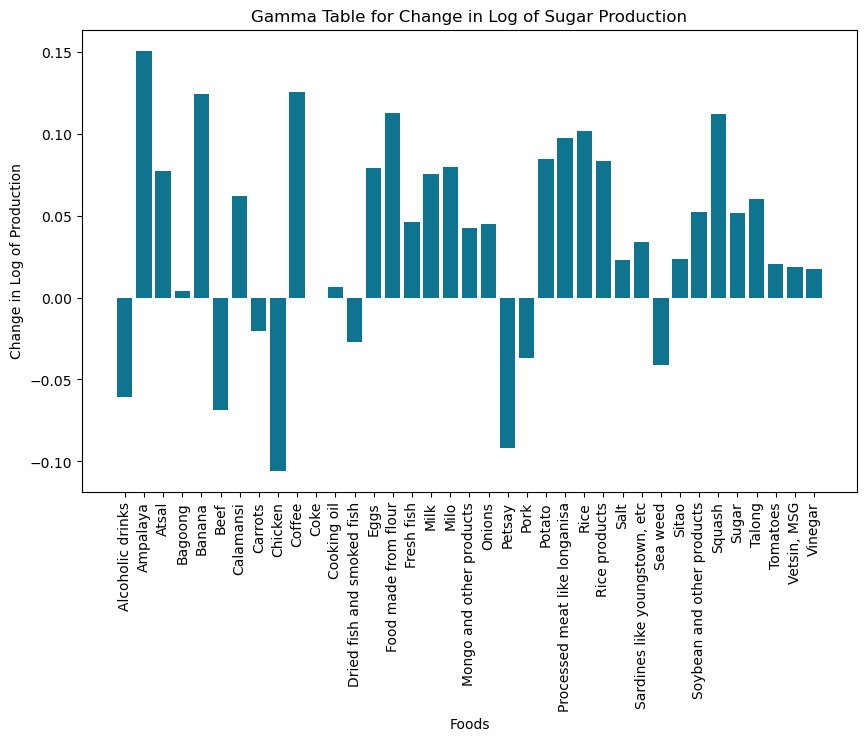

In [24]:
# Create a bar chart for log sugar production
def plot_gamma_table(gamma_table, variable_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    print("Index shape:", gamma_table.index.shape, "Values shape:", gamma_table.values.shape)


    ax.bar(gamma_table.index, gamma_table.values, color='#0e7490')
    ax.set_title(f'Gamma Table for Change in Log of {variable_name} Production')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Log of Production')
    plt.bar(color=['0e7490'])
    plt.xticks(rotation=90)
    plt.show()

def plot_gamma_table(gamma_table, variable_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Take the mean across the second dimension of the gamma table values array
    mean_values = gamma_table.values.mean(axis=1)

    ax.bar(gamma_table.index, mean_values, color='#0e7490')
    ax.set_title(f'Gamma Table for Change in Log of {variable_name} Production')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Log of Production')
    plt.xticks(rotation=90)
    plt.show()

    
# Plot the gamma table for log sugar production
plot_gamma_table(gamma_tables[0], 'Sugar')

In [25]:
# log rice production
gamma_tables[1]

k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,...,Females 5-10,Females 10-15,Females 15-20,Females 20-30,Females 30-50,Females 50-60,Females 60-100,log HSize,logRice,Constant
j,,,,,,,,,,,,,,,,,,,,,
Alcoholic drinks,0.189249,0.240226,-0.030405,-0.307573,0.135760,0.114486,0.172696,-0.207569,-0.376432,-0.717283,...,-0.029749,-0.008050,0.030126,0.052797,0.059178,0.026589,-0.206684,0.147414,0.020569,-0.534443
Ampalaya,0.254296,0.366111,0.374213,0.358821,0.310627,0.325674,0.154240,0.268736,0.194057,-0.680231,...,0.476334,0.284630,0.198931,0.087742,0.185096,0.278143,0.435383,-1.573265,0.019726,0.963702
Atsal,0.192926,0.165640,0.333463,-0.002007,0.109843,0.206972,0.060811,0.436904,0.115152,-0.022627,...,0.439557,0.038976,-0.082326,0.180185,0.108046,0.071336,-0.043672,-0.793677,0.016593,0.421066
Bagoong,0.284071,0.183227,0.018749,-0.040328,0.068428,0.084478,0.064542,0.278444,0.188374,-0.422910,...,0.149453,0.096706,0.158139,-0.084627,0.032434,-0.005482,-0.235854,0.204995,-0.004183,-0.745169
Banana,0.165854,0.201301,0.354759,0.283544,-0.036256,0.075530,-0.117264,0.388341,0.444295,-0.084672,...,0.405106,-0.065319,0.194683,-0.072590,0.409825,0.204729,0.244939,-0.707553,-0.000246,0.145808
Beef,-0.048266,-0.048453,0.038161,0.056097,-0.158860,0.097265,0.161718,0.288391,-0.039139,-0.478395,...,-0.043802,0.066706,-0.145765,-0.042380,-0.035237,-0.091035,-0.458323,0.243598,-0.002951,-0.704152
Calamansi,-0.253980,0.054124,0.286152,0.179581,0.171125,0.072326,0.028997,-0.450663,0.071135,0.029815,...,0.075422,0.235955,0.193707,0.141182,0.219199,0.494049,0.199620,-0.806950,0.006809,0.458063
Carrots,0.207069,0.097059,-0.236945,-0.022011,0.110635,-0.124850,-0.012321,-0.064703,0.095203,-0.378788,...,-0.079159,0.096111,0.158306,0.083309,0.286810,0.411030,-0.030127,-0.144498,0.046948,-0.432526
Chicken,0.130204,-0.143924,0.334967,-0.135488,-0.109565,-0.026662,-0.046799,0.107257,-0.066427,-0.459604,...,0.180505,-0.352055,-0.109260,0.109536,-0.172284,-0.100017,0.107051,1.081485,0.056565,-1.991285


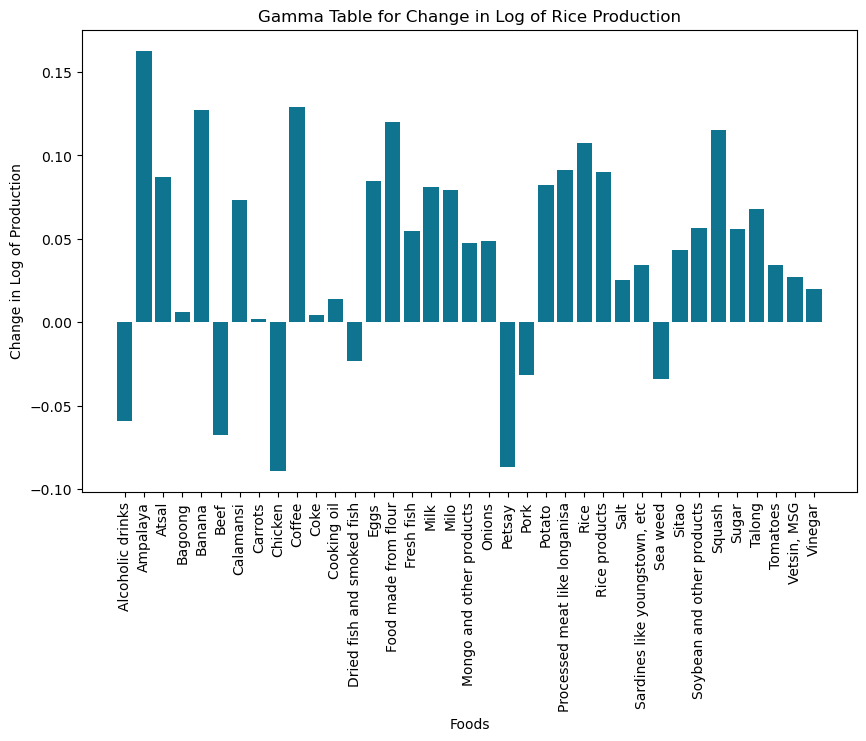

In [26]:
# Plot the gamma table for log rice production
plot_gamma_table(gamma_tables[1], 'Rice')

In [27]:
# log yellow corn production
gamma_tables[2]

k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,...,Females 5-10,Females 10-15,Females 15-20,Females 20-30,Females 30-50,Females 50-60,Females 60-100,log HSize,logYellow Corn,Constant
j,,,,,,,,,,,,,,,,,,,,,
Alcoholic drinks,0.185063,0.260273,-0.014597,-0.314123,0.156552,0.130806,0.177797,-0.204608,-0.334908,-0.720992,...,-0.031237,-0.018117,0.032156,0.051850,0.062551,0.008496,-0.215102,0.140789,0.019582,-0.547951
Ampalaya,0.236746,0.377812,0.351966,0.343179,0.302389,0.327798,0.143186,0.258738,0.212312,-0.702572,...,0.473831,0.275419,0.193078,0.086585,0.185582,0.268026,0.401967,-1.533161,-0.003931,0.971673
Atsal,0.210265,0.166541,0.265638,-0.023057,0.109722,0.183531,0.059535,0.477537,0.124702,-0.340347,...,0.426716,0.014461,-0.154220,0.122577,0.101776,-0.015127,-0.143071,-0.523701,0.051695,0.007301
Bagoong,0.290874,0.177552,0.021402,-0.043625,0.061455,0.083908,0.061939,0.269287,0.181831,-0.413410,...,0.150863,0.089502,0.155439,-0.088284,0.029801,-0.000601,-0.241931,0.221162,-0.006294,-0.752653
Banana,0.156763,0.183390,0.329341,0.296148,-0.028762,0.067335,-0.106654,0.424031,0.448271,-0.065605,...,0.411439,-0.088487,0.167023,-0.086798,0.414632,0.155148,0.242188,-0.661622,0.030340,0.018257
Beef,-0.073207,-0.041289,0.067478,0.067678,-0.147448,0.092242,0.167119,0.311014,-0.034627,-0.450177,...,-0.058156,0.077459,-0.124009,-0.037593,-0.024775,-0.090695,-0.430907,0.169509,-0.001583,-0.622554
Calamansi,-0.261475,0.050671,0.286768,0.176555,0.167858,0.069976,0.029103,-0.469921,0.059269,-0.007303,...,0.060509,0.236233,0.192973,0.142052,0.213895,0.493444,0.200792,-0.795998,0.000525,0.483699
Carrots,0.145211,0.085727,-0.267034,-0.050004,0.084763,-0.092333,-0.028650,-0.123757,0.093215,-0.481536,...,-0.096094,0.090578,0.114560,0.094980,0.279772,0.399833,-0.085846,-0.073766,-0.002361,-0.427399
Chicken,0.082222,-0.091843,0.240678,-0.228782,-0.106204,-0.020883,-0.046619,0.019795,-0.050043,-0.587400,...,0.144615,-0.353517,-0.136535,0.072707,-0.148290,-0.103157,0.032884,1.244431,0.013144,-2.110948


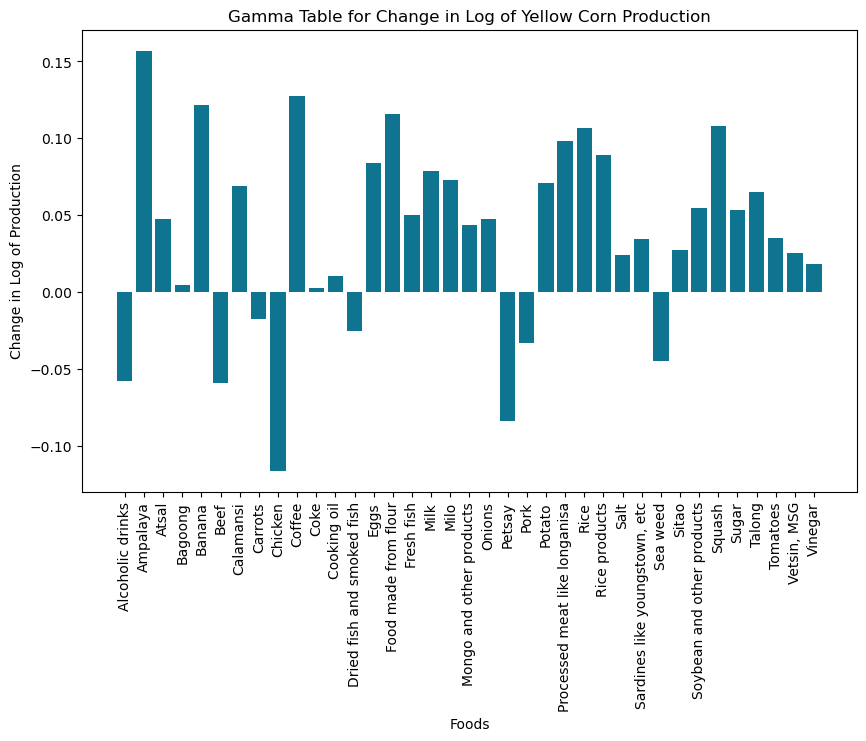

In [28]:
# Plot the gamma table for log yellow corn production
plot_gamma_table(gamma_tables[2], 'Yellow Corn')

In [29]:
# log white corn production
gamma_tables[3]

k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,...,Females 5-10,Females 10-15,Females 15-20,Females 20-30,Females 30-50,Females 50-60,Females 60-100,log HSize,logWhite Corn,Constant
j,,,,,,,,,,,,,,,,,,,,,
Alcoholic drinks,0.148008,0.257597,-0.041430,-0.329777,0.157458,0.113686,0.186287,-0.210604,-0.357514,-0.751254,...,-0.051244,-0.014562,0.040445,0.038769,0.048862,0.003376,-0.210277,0.189702,-0.028445,-0.493014
Ampalaya,0.233375,0.399537,0.326138,0.336615,0.282926,0.340340,0.148236,0.213571,0.197835,-0.566208,...,0.506316,0.309993,0.208982,0.127496,0.192001,0.312589,0.482193,-1.687071,0.056447,1.102400
Atsal,0.167231,0.198120,0.324821,-0.053263,0.138860,0.201449,0.063355,0.442886,0.153936,-0.083133,...,0.420112,0.008336,-0.075213,0.165237,0.108546,0.031231,-0.112625,-0.700932,-0.041212,0.390736
Bagoong,0.289314,0.181935,0.020520,-0.042108,0.064511,0.083552,0.062432,0.273676,0.182188,-0.417165,...,0.148121,0.086755,0.154178,-0.089375,0.033000,-0.001316,-0.246220,0.220478,-0.002365,-0.762681
Banana,0.150203,0.196320,0.360573,0.276697,-0.020632,0.065909,-0.110202,0.404196,0.445287,-0.111695,...,0.389648,-0.075110,0.199957,-0.078732,0.408410,0.189904,0.243326,-0.683122,-0.017145,0.140591
Beef,-0.055584,-0.057454,0.049801,0.070860,-0.159361,0.088028,0.164717,0.301809,-0.046271,-0.427045,...,-0.056924,0.088082,-0.129671,-0.044553,-0.035572,-0.078504,-0.421974,0.212856,0.012570,-0.693883
Calamansi,-0.208574,0.013184,0.332556,0.269751,0.198904,0.115026,0.029220,-0.541071,0.069921,0.050071,...,0.094613,0.245164,0.225751,0.180296,0.175833,0.543067,0.288828,-0.963335,0.052095,0.596324
Carrots,0.161930,0.085223,-0.269330,-0.057374,0.082527,-0.098339,-0.027098,-0.102869,0.095964,-0.506053,...,-0.119543,0.089219,0.119101,0.081821,0.277485,0.384492,-0.119458,-0.015804,-0.018824,-0.483103
Chicken,0.097627,-0.107305,0.249274,-0.218298,-0.118594,-0.016504,-0.045506,-0.005936,-0.046155,-0.549745,...,0.158516,-0.314332,-0.129684,0.100856,-0.137511,-0.056179,0.088636,1.151832,0.017570,-1.996423


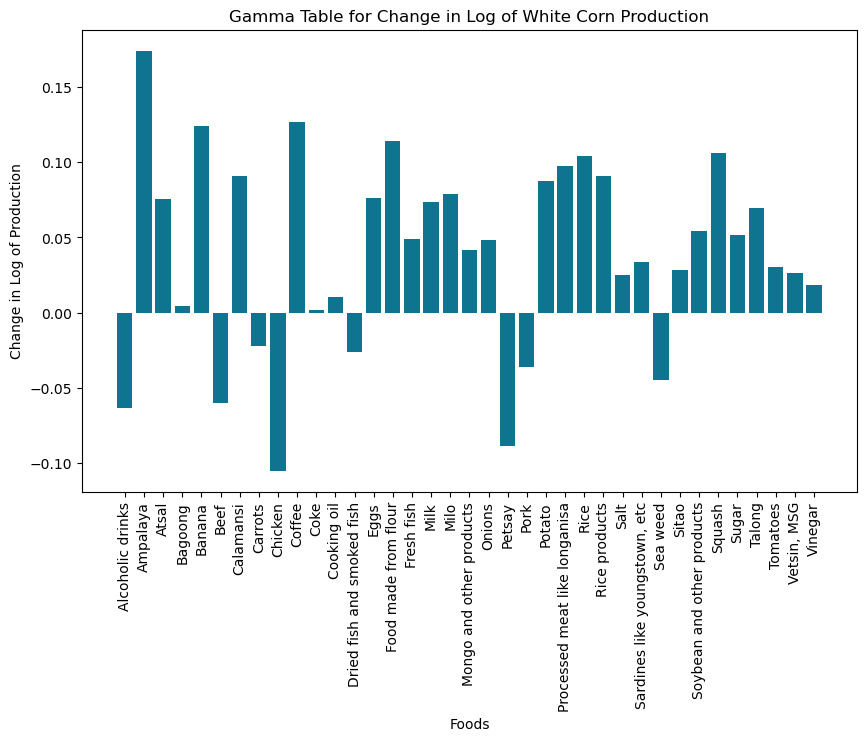

In [30]:
# Plot the gamma table for log white corn production
plot_gamma_table(gamma_tables[3], 'White Corn')

In [31]:
# log rubber production
gamma_tables[4]

k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,...,Females 5-10,Females 10-15,Females 15-20,Females 20-30,Females 30-50,Females 50-60,Females 60-100,log HSize,logRubber,Constant
j,,,,,,,,,,,,,,,,,,,,,
Alcoholic drinks,0.187638,0.234993,-0.037492,-0.328209,0.126712,0.120499,0.169596,-0.196826,-0.357365,-0.692423,...,-0.020890,-0.004710,0.017676,0.054284,0.048156,0.017933,-0.227311,0.200330,-0.009369,-0.550975
Ampalaya,0.194196,0.438708,0.330313,0.348474,0.348981,0.348934,0.181707,0.270555,0.262082,-0.696029,...,0.462065,0.302233,0.219671,0.127373,0.234199,0.289809,0.453764,-1.772401,-0.049411,1.250639
Atsal,0.187414,0.162780,0.322467,-0.020913,0.100542,0.210022,0.056740,0.419768,0.126955,-0.064760,...,0.438865,0.042868,-0.094681,0.183099,0.105663,0.067858,-0.048370,-0.764549,-0.005246,0.436948
Bagoong,0.311008,0.185683,0.021807,-0.043781,0.063802,0.085996,0.065484,0.281808,0.192091,-0.406673,...,0.148382,0.093645,0.151008,-0.084686,0.034199,-0.006078,-0.251297,0.216791,-0.010184,-0.770616
Banana,0.156620,0.198552,0.352326,0.284473,-0.033413,0.070456,-0.111568,0.390275,0.446682,-0.126092,...,0.399373,-0.060005,0.196814,-0.077419,0.410922,0.203826,0.260366,-0.714380,-0.000330,0.155306
Beef,-0.070938,-0.052851,0.058863,0.053262,-0.152236,0.087857,0.165430,0.300341,-0.043772,-0.491416,...,-0.078838,0.059839,-0.141526,-0.032710,-0.032246,-0.094234,-0.423092,0.234628,-0.007136,-0.695203
Calamansi,-0.276916,0.051572,0.289357,0.166651,0.175012,0.070644,0.026315,-0.438018,0.074666,-0.012370,...,0.070694,0.246122,0.197357,0.143342,0.226684,0.519305,0.185891,-0.819534,-0.015342,0.508306
Carrots,0.148860,0.084074,-0.273695,-0.038856,0.080811,-0.093280,-0.033496,-0.127210,0.078068,-0.485542,...,-0.093840,0.085763,0.110250,0.086120,0.275244,0.384552,-0.105574,-0.055287,0.016502,-0.454361
Chicken,0.071958,-0.068675,0.234364,-0.245655,-0.082996,-0.012886,-0.040853,0.008659,-0.064166,-0.606751,...,0.137120,-0.326082,-0.123435,0.093910,-0.110426,-0.035516,0.070134,1.163266,-0.030722,-2.017290


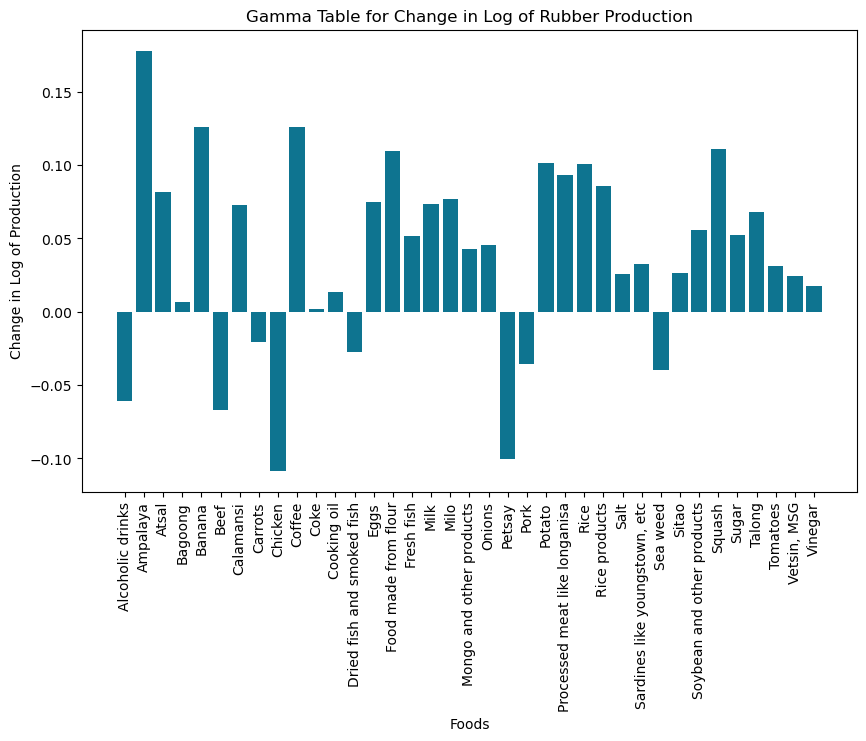

In [32]:
# Plot the gamma table for log rubber production
plot_gamma_table(gamma_tables[4], 'Rubber')

In [33]:
# log coconut production
gamma_tables[5]

k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,...,Females 5-10,Females 10-15,Females 15-20,Females 20-30,Females 30-50,Females 50-60,Females 60-100,log HSize,logCoconut,Constant
j,,,,,,,,,,,,,,,,,,,,,
Alcoholic drinks,0.137816,0.277845,0.001484,-0.280001,0.128273,0.125209,0.162534,-0.226414,-0.369681,-0.727969,...,-0.019736,0.015330,0.048788,0.062976,0.024138,0.071386,-0.197338,0.062911,0.081557,-0.397724
Ampalaya,0.232125,0.377340,0.348687,0.351014,0.306987,0.334435,0.145134,0.255732,0.204750,-0.693808,...,0.481038,0.278549,0.193552,0.086777,0.182991,0.265099,0.397727,-1.545589,0.004490,0.968493
Atsal,0.158719,0.179268,0.353891,0.015759,0.111660,0.215966,0.049931,0.418491,0.117579,-0.033423,...,0.451693,0.041563,-0.066350,0.182928,0.102483,0.106519,-0.054041,-0.858050,0.044278,0.534991
Bagoong,0.277132,0.185529,0.045738,-0.014099,0.073543,0.093273,0.062671,0.269140,0.174740,-0.409639,...,0.169534,0.098060,0.160098,-0.088647,0.026703,0.035586,-0.243393,0.136521,0.051062,-0.685343
Banana,0.154969,0.198329,0.369743,0.295404,-0.033665,0.077263,-0.112807,0.390825,0.446898,-0.110832,...,0.405444,-0.059456,0.201926,-0.074406,0.405227,0.215795,0.259626,-0.749458,0.023450,0.188601
Beef,-0.089223,-0.026156,0.074123,0.076115,-0.147046,0.097893,0.164119,0.316587,-0.022695,-0.428246,...,-0.059307,0.070429,-0.104340,-0.036487,-0.024443,-0.084710,-0.441732,0.120139,0.041094,-0.568093
Calamansi,-0.170879,0.008737,0.243473,0.180588,0.146662,0.056974,0.046795,-0.468565,0.020401,-0.028950,...,0.051010,0.219282,0.153402,0.135699,0.213606,0.432203,0.291392,-0.681644,-0.076013,0.362541
Carrots,0.080881,0.087394,-0.215727,0.026540,0.090152,-0.064205,-0.039757,-0.162226,0.049323,-0.506670,...,-0.067093,0.097793,0.131251,0.100223,0.277980,0.482178,-0.087661,-0.251147,0.072313,-0.231192
Chicken,0.078870,-0.103057,0.263731,-0.194828,-0.097387,-0.011779,-0.054570,0.002695,-0.041074,-0.553945,...,0.165510,-0.324765,-0.091302,0.100415,-0.162947,-0.069668,0.036641,1.136476,0.035186,-1.967962


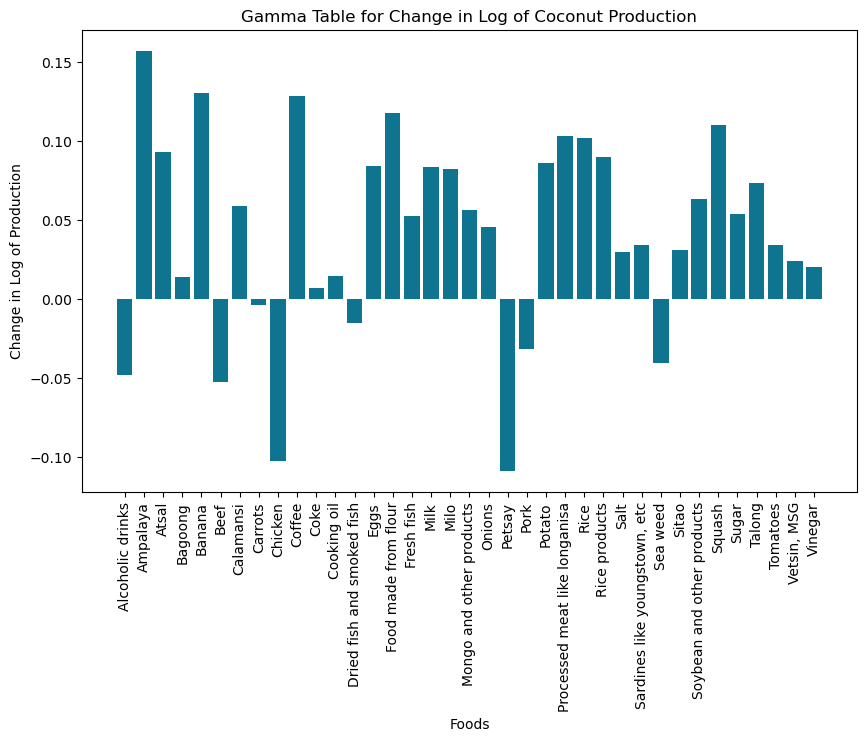

In [34]:
# Plot the gamma table for log coconut production
plot_gamma_table(gamma_tables[5], 'Coconut')

In [35]:
# log land area
gamma_tables[6]

k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,...,Females 5-10,Females 10-15,Females 15-20,Females 20-30,Females 30-50,Females 50-60,Females 60-100,log HSize,logLand Area,Constant
j,,,,,,,,,,,,,,,,,,,,,
Alcoholic drinks,0.133690,0.003717,-0.037136,-0.192528,0.100238,0.186036,0.223101,-0.231897,-0.321707,-0.237693,...,-0.131582,0.093646,-0.090917,-0.003323,-0.019776,-0.079285,0.090825,-0.039893,0.226310,-0.189506
Ampalaya,0.020342,0.377777,0.268925,0.249047,0.184308,0.209536,0.126356,0.089049,0.043776,-0.170439,...,0.287704,0.188019,0.164716,0.108406,0.144935,0.121460,0.096340,-0.992928,0.195508,0.386837
Atsal,0.070210,0.217994,0.326775,0.015129,0.111993,0.124273,0.060672,0.218807,0.000163,0.369356,...,0.324725,0.035215,-0.022161,0.120660,0.116925,-0.001252,-0.009357,-0.582554,0.208474,0.154499
Bagoong,-0.085694,0.103538,0.098985,0.008449,0.067054,0.045528,0.052045,0.160714,0.136168,-0.283354,...,0.147572,0.052289,0.060642,-0.108154,0.008736,0.000884,-0.164839,0.292483,0.047987,-0.731048
Banana,0.260115,0.222706,0.302919,0.230246,-0.062838,0.078461,-0.067703,0.087371,0.332715,0.009435,...,0.258781,0.050256,0.083236,0.026762,0.228370,0.189388,0.173160,-0.710591,0.265699,0.340516
Beef,0.155954,0.054547,0.046187,0.106317,-0.065745,0.046902,0.118608,0.361789,-0.017471,0.078897,...,-0.022074,-0.019587,0.052803,-0.014806,0.055732,-0.212757,-0.105128,-0.195162,0.232292,-0.206266
Calamansi,-0.176436,-0.008827,0.144181,0.164461,0.111627,0.001017,-0.041044,-0.525387,-0.035643,0.299841,...,0.081398,0.226692,-0.091627,0.120483,0.165300,0.393446,0.087629,-0.248888,0.139698,-0.150422
Carrots,0.122825,0.280385,-0.122914,-0.102170,-0.021037,-0.190606,-0.084275,-0.237361,0.071758,0.103164,...,-0.242899,-0.001055,0.158475,0.092037,0.328670,0.361782,-0.059757,-0.024720,0.213464,-0.428345
Chicken,0.091461,0.085706,0.210258,-0.020464,0.016660,-0.020734,-0.036215,0.126706,-0.182338,-0.140610,...,0.134768,0.034964,0.005214,0.125945,-0.099451,-0.082822,0.130572,0.453004,0.309652,-1.153675


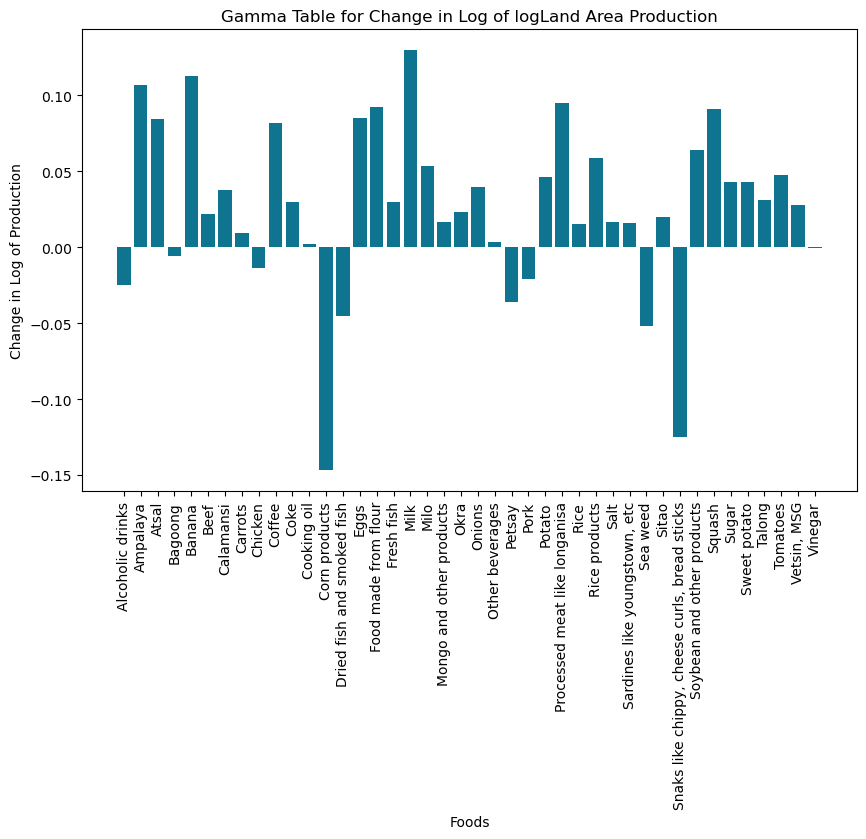

In [36]:
# Plot the gamma table for log land area
plot_gamma_table(gamma_tables[6], 'logLand Area')

In [37]:
# had shocks
gamma_tables[7]

k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,...,Females 5-10,Females 10-15,Females 15-20,Females 20-30,Females 30-50,Females 50-60,Females 60-100,log HSize,Had Shocks,Constant
j,,,,,,,,,,,,,,,,,,,,,
Alcoholic drinks,0.107722,-0.032640,-0.058999,-0.216692,0.098427,0.197295,0.256011,-0.224916,-0.305581,-0.287186,...,-0.106320,0.079033,-0.075256,-0.001300,0.007095,-0.016746,0.101702,0.071251,-0.230783,-0.189947
Ampalaya,0.069220,0.398855,0.294378,0.260748,0.194004,0.251639,0.171223,0.080006,0.075981,-0.122792,...,0.319146,0.189951,0.192539,0.143020,0.193217,0.196488,0.140405,-1.146463,0.128667,0.432456
Atsal,0.004172,0.189181,0.300828,0.010071,0.112007,0.140350,0.097369,0.210194,0.004609,0.329623,...,0.326061,0.013079,-0.005673,0.129966,0.131446,0.039959,-0.021549,-0.438156,-0.258129,0.121264
Bagoong,-0.098366,0.095609,0.087346,0.008886,0.063570,0.051475,0.055990,0.152001,0.139748,-0.299227,...,0.151466,0.045076,0.058958,-0.108876,0.014155,0.015083,-0.167904,0.329764,-0.055732,-0.741278
Banana,0.232707,0.205719,0.278997,0.234581,-0.066361,0.115978,-0.026193,0.082036,0.368615,-0.033081,...,0.290232,0.037946,0.100189,0.047106,0.263291,0.252349,0.171655,-0.646704,-0.150349,0.310733
Beef,0.134586,0.028135,0.024568,0.109699,-0.062723,0.069011,0.135142,0.344458,-0.007558,0.047790,...,-0.006119,-0.027080,0.059262,-0.008607,0.071825,-0.125513,-0.097573,-0.052459,-0.221652,-0.267119
Calamansi,-0.234108,-0.027483,0.123133,0.160014,0.125776,0.015217,-0.023339,-0.516764,-0.016792,0.284136,...,0.071617,0.210815,-0.083906,0.126995,0.178132,0.397427,0.090568,-0.174219,-0.190192,-0.116034
Carrots,0.114886,0.256757,-0.135225,-0.101043,-0.020687,-0.160780,-0.050507,-0.245401,0.105149,0.075118,...,-0.227633,-0.017743,0.183781,0.108288,0.354150,0.412139,-0.066075,0.042795,-0.120289,-0.464128
Chicken,0.099022,0.087393,0.183628,-0.011346,0.013641,0.032290,0.018193,0.121584,-0.137235,-0.119753,...,0.170309,0.020512,0.024027,0.144119,-0.054764,-0.000236,0.165493,0.445310,0.037047,-1.238602


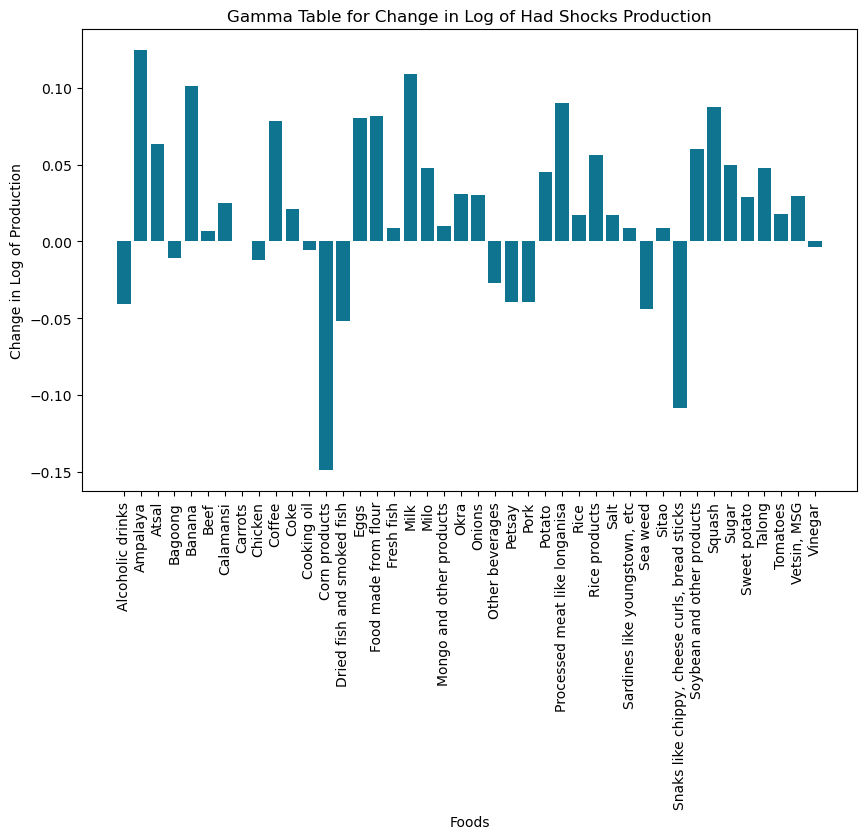

In [38]:
# Plot the gamma table for shocks
plot_gamma_table(gamma_tables[7], 'Had Shocks')

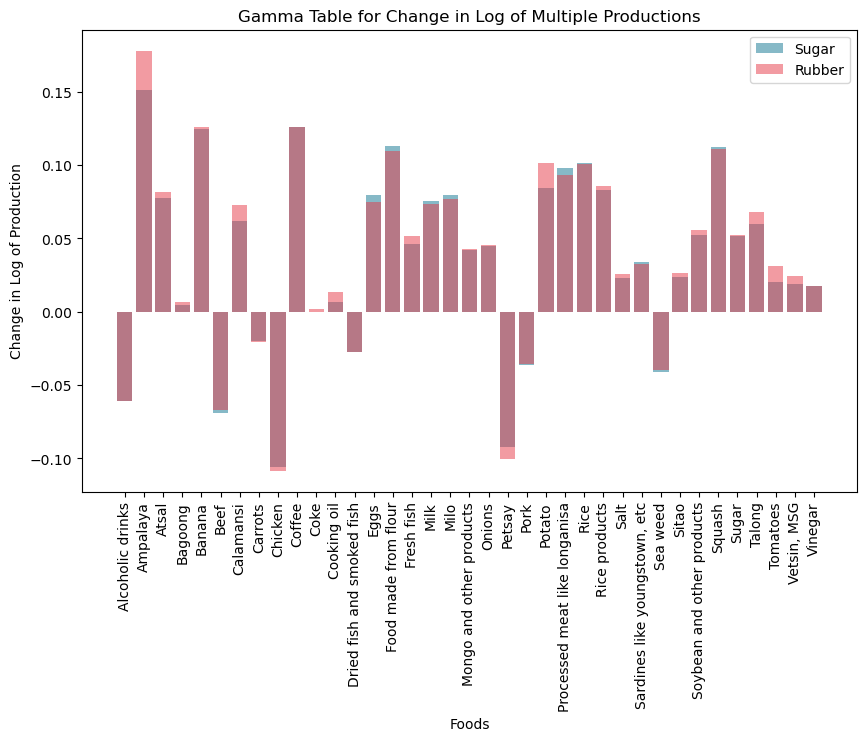

In [57]:
def plot_multiple_gamma_tables(gamma_tables, variable_names):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Set the common labels and title
    ax.set_title('Gamma Table for Change in Log of Multiple Productions')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Log of Production')
    plt.xticks(rotation=90)

    # Define colors for each production variable
    colors = ['#0e7490', '#e63946', '#f1c40f']

    for i, (gamma_table, variable_name) in enumerate(zip(gamma_tables, variable_names)):
        # Take the mean across the second dimension of the gamma table values array
        mean_values = gamma_table.values.mean(axis=1)
        
        # Create the bars with lowered opacity (alpha) and label them
        ax.bar(gamma_table.index, mean_values, color=colors[i % len(colors)], alpha=0.5, label=variable_name)

    # Add a legend to the graph
    ax.legend()
    plt.show()

plot_multiple_gamma_tables([gamma_tables[0], gamma_tables[4]], ['Sugar','Rubber'])

In [39]:
#%matplotlib notebook
#df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
#df.plot.scatter(x='yhat',y='y')

In [40]:
#result.get_beta().sort_values()
#result.graph_beta()
#result.gamma